In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

from data_generator import DataGeneratorMatting
from preprocess import scale, descale

In [13]:
# selfie
selfie_train_x = [os.path.join("./dataset/selfie/training/", x)
                  for x in sorted(os.listdir("./dataset/selfie/training/")) if 'matte' not in x]
selfie_train_y = [os.path.join("./dataset/selfie/training/", x)
                  for x in sorted(os.listdir("./dataset/selfie/training/")) if 'matte' in x]
selfie_test_x = [os.path.join("./dataset/selfie/testing/", x)
                 for x in sorted(os.listdir("./dataset/selfie/testing/")) if 'matte' not in x]
selfie_test_y = [os.path.join("./dataset/selfie/testing/", x)
                 for x in sorted(os.listdir("./dataset/selfie/testing/")) if 'matte' in x]

In [14]:
# supervisely dataset 
supervisely_x = []

for ds in [os.path.join('./dataset/Supervisely_person_dataset/', x)
           for x in os.listdir('./dataset/Supervisely_person_dataset/') if 'ds' in x]:

    supervisely_x = supervisely_x +\
        [os.path.join(ds, "img", x) for x in os.listdir(
            os.path.join(ds, "img")) if x.endswith(".png")]
    
supervisely_y = [x.replace("/img/", "/alpha/") for x in supervisely_x]

In [15]:
# [os.path.join("./dataset/Custom/img/", x) for x in sorted(os.listdir("./dataset/Custom/img/")) if x != ".DS_Store"]

In [16]:
idx = 91
selfie_test_x[idx], selfie_test_y[idx]

('./dataset/selfie/testing/00092.png',
 './dataset/selfie/testing/00092_matte.png')

### Background image crawling

### Cut mix

scale random space 
 - background image's 0.5 ~ 0.8

* algorithm 
  1. make a box onto Human
  2. randomly choose backgrounds (10 ~ 30)
  3. overlay human box onto backgrounds (random size, location and rotation)
  
  
###### WIll DO LATER
```
base_dir  = "./dataset/cut_mix"
img_dir   = "./dataset/cut_mix/img/"
alpha_dir = "./dataset/cut_mix/alpha/"
```

### Copy Blob 

In [17]:
def get_img(path):
    return cv2.imread(path)[:,:,::-1]
def get_mask(path):
    return cv2.imread(path)

In [19]:
def get_copy_blob_img(img_path, mask_path, background_path):

    img = get_img(img_path)
    mask = get_img(mask_path)
    back = get_img(background_path)

    gray = mask.max(axis=-1)[:, :, np.newaxis]

    blob = np.uint8(img * (gray/255))

    back_h, back_w = back.shape[:2]
    
    r_scale = [0.4, 0.8]
    c_h = np.random.randint(int(back_h*r_scale[0]), int(back_h*r_scale[1]))
    c_w = np.random.randint(int(back_w*r_scale[0]), int(back_w*r_scale[1]))
    
    c_y = np.random.randint(0, (back_h - c_h))
    c_x = np.random.randint(0, (back_w - c_w))

    resized_blob = cv2.resize(blob, (c_w, c_h))
    resized_gray = cv2.resize(gray, (c_w, c_h))

    multiplier_gray = 1 - (resized_gray[:, :, np.newaxis] / 255)

    back[c_y:c_y+c_h, c_x:c_x+c_w] = multiplier_gray * back[c_y:c_y+c_h, c_x:c_x+c_w]
    back[c_y:c_y+c_h, c_x:c_x+c_w] = resized_blob    + back[c_y:c_y+c_h, c_x:c_x+c_w]

    blob_x = back
    blob_y = np.zeros_like(back)
    blob_y[c_y:c_y+c_h, c_x:c_x+c_w] = resized_gray[:, :, np.newaxis] + blob_y[c_y:c_y+c_h, c_x:c_x+c_w]

    return np.uint8(blob_x), np.uint8(blob_y)

In [20]:
base_dir  = "./dataset/copy_blob"
img_dir   = "./dataset/copy_blob/img/"
alpha_dir = "./dataset/copy_blob/alpha/"

In [21]:
human_bank  = selfie_train_x + selfie_test_x + supervisely_x
backgrounds = [os.path.join('./dataset/BlankDataset/', x) for x in os.listdir('./dataset/BlankDataset/')]

In [22]:
c = 0
while c < 3000:
    img_path  = np.random.choice(human_bank)
    if 'Supervisely' not in img_path:
        mask_path = img_path.replace(".png", "_matte.png")
    else :
        mask_path = img_path.replace("/img/", "/alpha/")
    
    mask = get_img(mask_path)
    back_path = np.random.choice(backgrounds)
    
    if 0.15 > np.count_nonzero(mask) / mask.flatten().shape[0]:
        continue
        
    try : 
        blob_x, blob_y = get_copy_blob_img(img_path, mask_path, back_path)
    except:
        continue
        
    c += 1
    
    t_img_path  = os.path.join(img_dir, img_path.split('/')[-1])
    t_mask_path = os.path.join(alpha_dir, img_path.split('/')[-1])
    
    
    if 800 < blob_x.shape[0] or 800 < blob_x.shape[1]:
        blob_x = cv2.resize(blob_x, dsize=None, fx=0.5, fy=0.5)
        blob_y = cv2.resize(blob_y, dsize=None, fx=0.5, fy=0.5)
        
    cv2.imwrite(t_img_path,  blob_x[:,:,::-1])
    cv2.imwrite(t_mask_path, blob_y)

KeyboardInterrupt: 

In [37]:
idx = 121
testx, testy = supervisely_x[idx], supervisely_y[idx]
testx, testy

('./dataset/Supervisely_person_dataset/ds1/img/pexels-photo-459947.png',
 './dataset/Supervisely_person_dataset/ds1/alpha/pexels-photo-459947.png')

In [38]:
blob_x, blob_y = get_copy_blob_img(testx, testy, "./dataset/BlankDataset/1.LEAD.jpg")

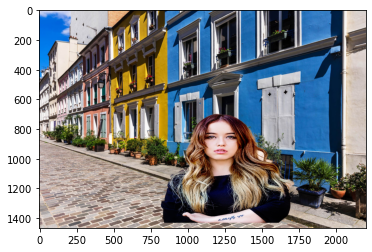

In [39]:
plt.imshow(blob_x)

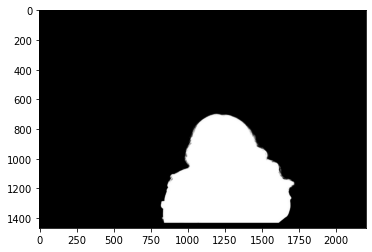

In [40]:
plt.imshow(blob_y)